# Image Registration

This notebook explores the results of different image registration algorithms for both normal images and coronagraphic images with satellite spots. This notebook can be downloaded as **{nb-download}`image_registration.ipynb`**.

## Setup and Imports

In [1]:
from astropy.io import fits
import numpy as np
from pathlib import Path
import proplot as pro
from zenodo_get import zenodo_get

pro.rc["style"] = "ggplot"
pro.rc["image.origin"] = "lower"
datadir = Path("data")

In [2]:
# download example data
zenodo_get(["10.5281/zenodo.7353462", "-o", datadir.absolute()])

Title: VAMPIRES DPP Example Files
Keywords: 
Publication date: 2022-11-24
DOI: 10.5281/zenodo.7353462
Total size: 231.0 MB

Link: https://zenodo.org/api/files/cc9ed3d2-b13e-4d43-a50c-db8c33f84c42/ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits   size: 100.0 MB


ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/cc9ed3d2-b13e-4d43-a50c-db8c33f84c42/ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits   size: 31.0 MB
ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/cc9ed3d2-b13e-4d43-a50c-db8c33f84c42/bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits   size: 100.0 MB


bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits is already downloaded correctly.
All files have been downloaded.


## Example 1: Speckle Imaging (Non-coronagraphic)

This example uses non-coronagraphic data of AB Aurigae from 2019/03/20. This data was taken in polarimetric imaging mode, but we will ignore that. This data has high signal-to-noise ratio (S/N), but suffers from low wind effect (LWE) causing PSF splitting. This means we have to be careful about which frame we use a reference for the cross-correlation method.

In [3]:
abaur20190320_cube = fits.getdata(
    datadir / "ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits"
)

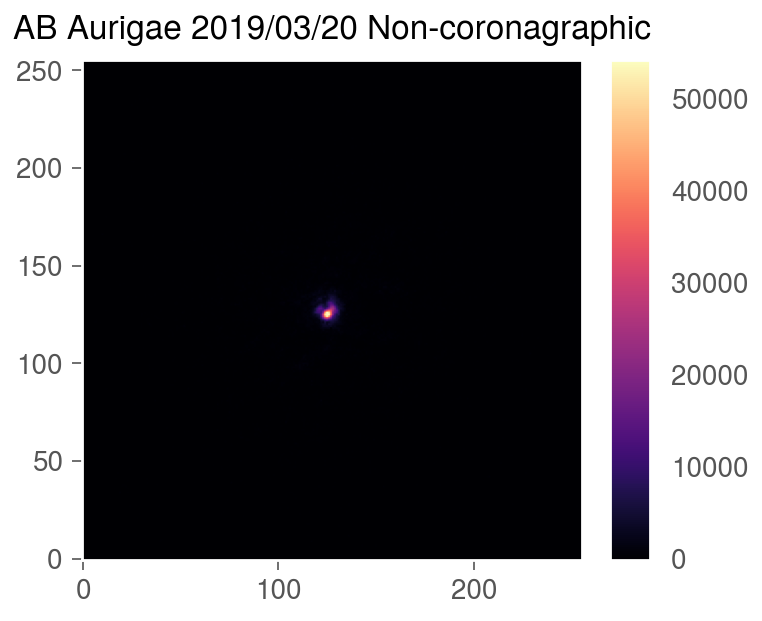

In [4]:
fig, axes = pro.subplots()
frame_idx = 248

frame = abaur20190320_cube[frame_idx]

c = axes[0].imshow(frame, cmap="magma")
fig.colorbar(c)
axes.format(grid=False)
fig.suptitle("AB Aurigae 2019/03/20 Non-coronagraphic");

In [5]:
from vampires_dpp.image_registration import psf_offsets

kwargs = dict(center=(128, 128), window=30)

offsets_com = psf_offsets(abaur20190320_cube, method="com", **kwargs)
offsets_peak = psf_offsets(abaur20190320_cube, method="peak", **kwargs)
offsets_dft = psf_offsets(
    abaur20190320_cube, method="dft", refidx=frame_idx, upsample_factor=1, **kwargs
)
offsets_dft_10 = psf_offsets(
    abaur20190320_cube, method="dft", refidx=frame_idx, upsample_factor=10, **kwargs
)
offsets_moffat = psf_offsets(abaur20190320_cube, method="moffat", **kwargs)
offsets_gaussian = psf_offsets(abaur20190320_cube, method="gaussian", **kwargs)
offsets_airydisk = psf_offsets(abaur20190320_cube, method="airydisk", **kwargs)

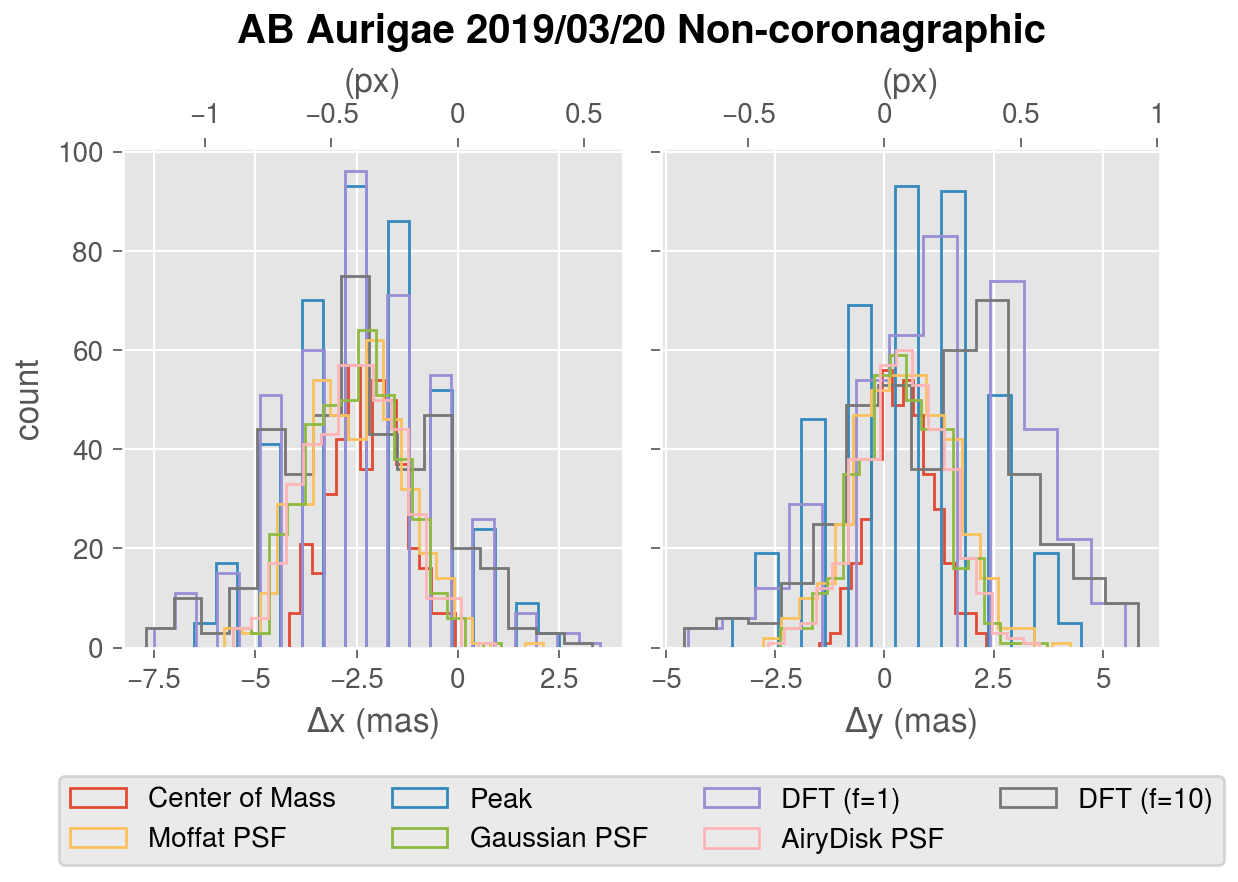

In [6]:
fig, axes = pro.subplots(sharex=0, ncols=2)

labels = [
    "Center of Mass",
    "Peak",
    "DFT (f=1)",
    "DFT (f=10)",
    "Moffat PSF",
    "Gaussian PSF",
    "AiryDisk PSF",
]
offsets = [
    offsets_com,
    offsets_peak,
    offsets_dft,
    offsets_dft_10,
    offsets_moffat,
    offsets_gaussian,
    offsets_airydisk,
]


for label, samples in zip(labels, offsets):
    axes[0].hist(samples[:, 1], bins="auto", fill=False, lw=1, label=label)
    axes[1].hist(samples[:, 0], bins="auto", fill=False, lw=1)
axes[0].format(xlabel=r"$\Delta$x (mas)", ylabel="count")
axes[1].format(xlabel=r"$\Delta$y (mas)")
axes.dualx(lambda a: a / 6.24, label="(px)")
fig.format(suptitle="AB Aurigae 2019/03/20 Non-coronagraphic")
fig.legend(loc="bottom", ncols=4);

In [7]:
from vampires_dpp.image_processing import shift_cube, shift_frame

collapsed_frames = []
for offset in offsets:
    registered_cube = shift_cube(abaur20190320_cube, -offset)
    collapsed_frames.append(np.median(registered_cube, axis=0, overwrite_input=True))

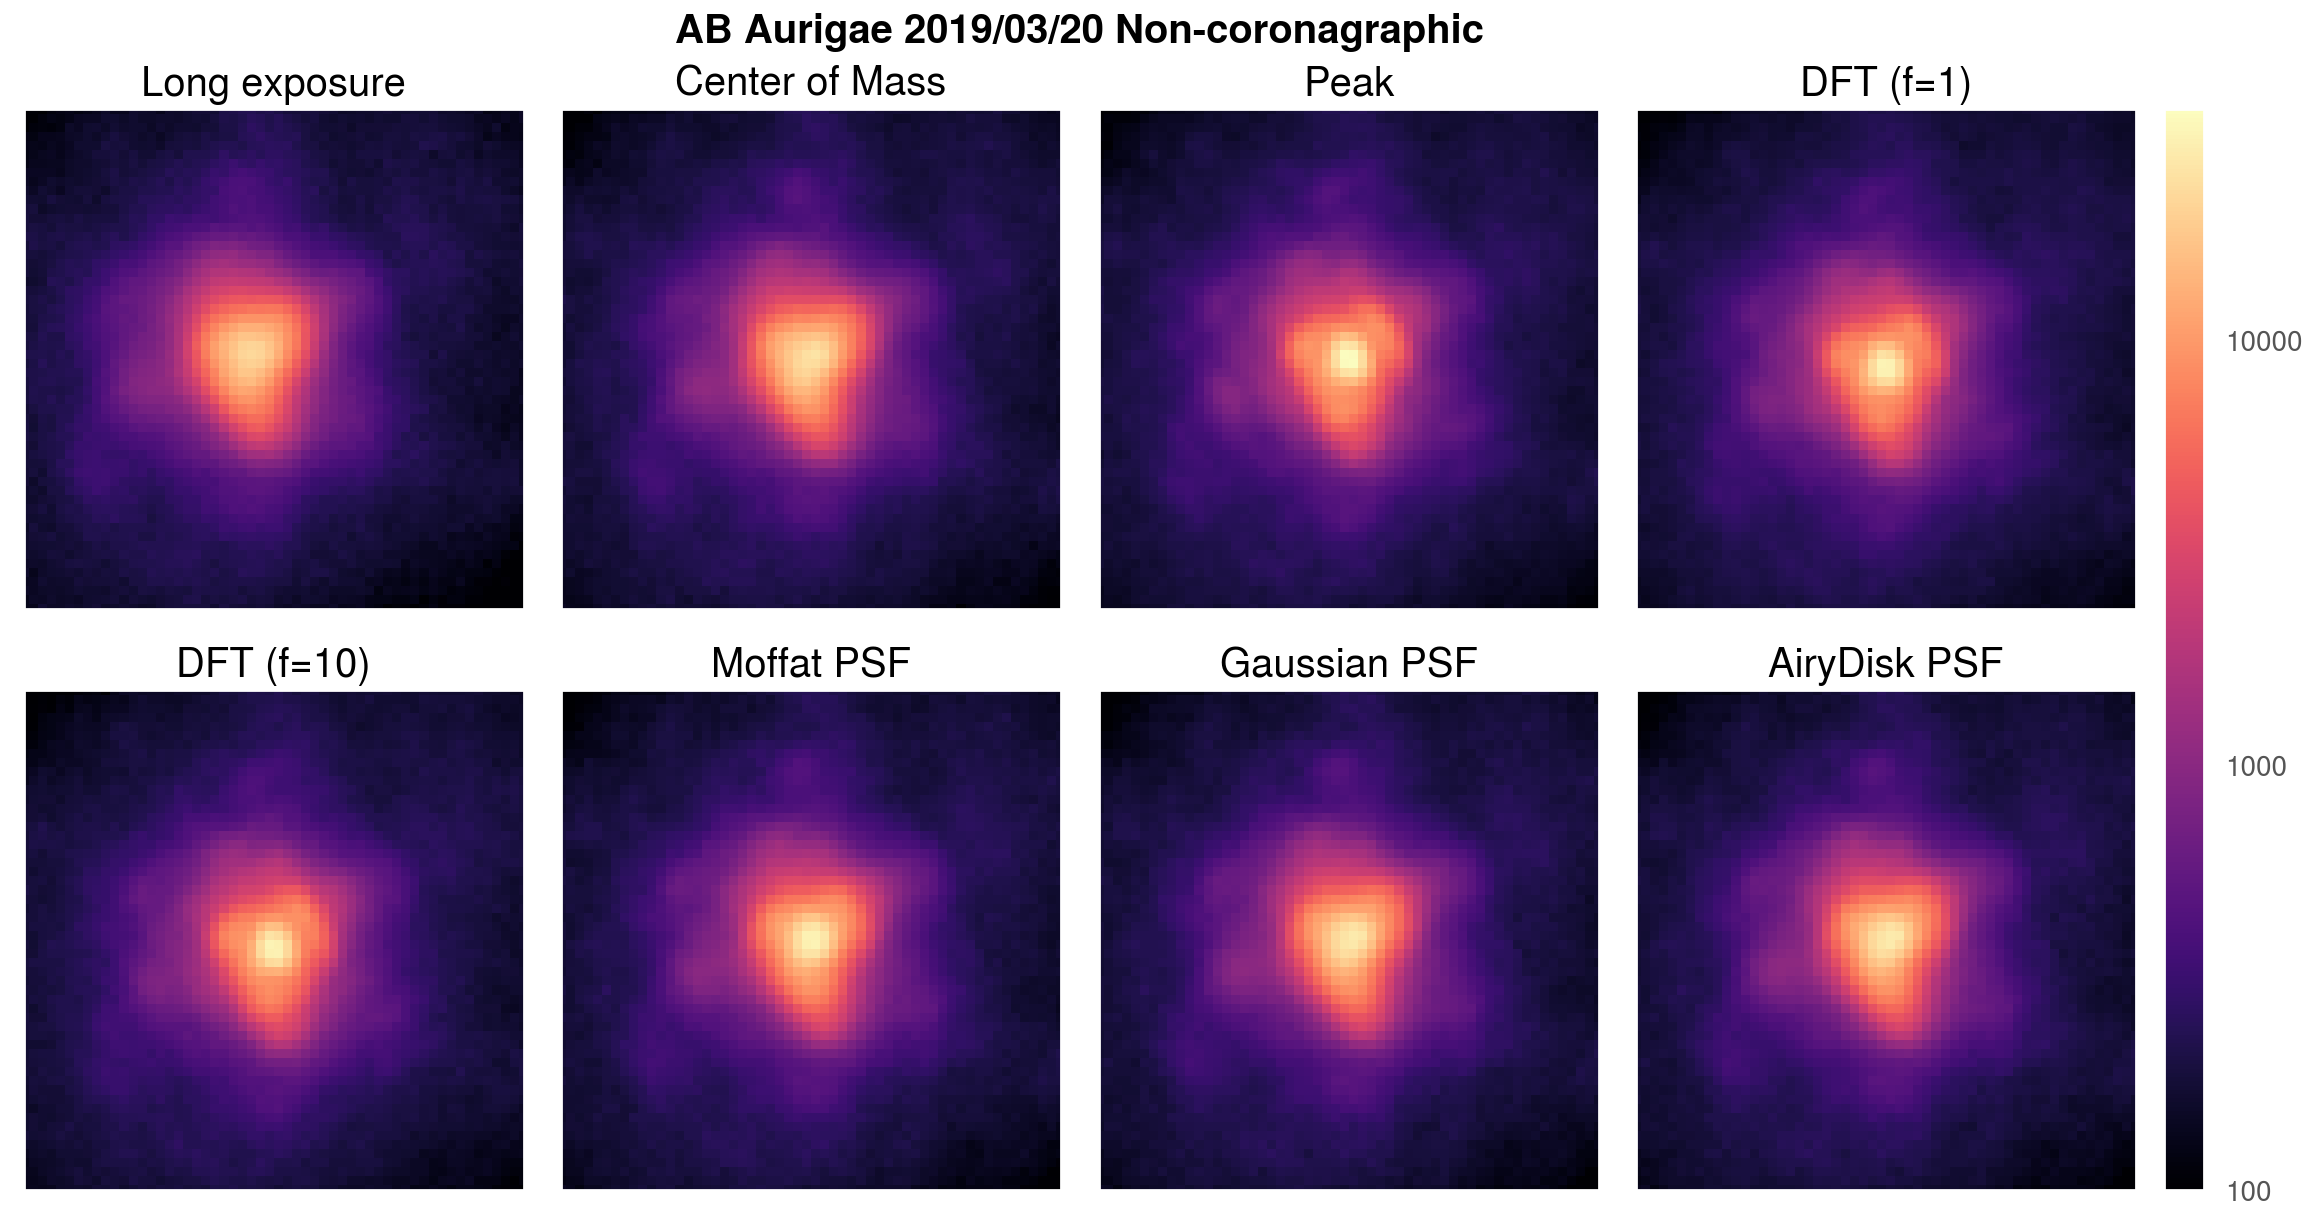

In [8]:
fig, axes = pro.subplots(nrows=2, ncols=4)

long_expo = np.median(abaur20190320_cube, 0)

c = axes[0].imshow(
    long_expo, origin="lower", cmap="magma", norm="log", vmin=100, vmax=3.5e4
)
axes[0].format(title="Long exposure")
fig.colorbar(c)

for i, frame, label in zip(range(1, 8), collapsed_frames, labels):
    axes[i].imshow(
        frame, origin="lower", cmap="magma", norm="log", vmin=100, vmax=3.5e4
    )
    axes[i].format(title=label)

axes.format(xticks=False, yticks=False, xlim=(100, 155), ylim=(100, 155))
fig.format(suptitle="AB Aurigae 2019/03/20 Non-coronagraphic");

## Example 2: Coronagraphic data with Satellite Spots

This example uses coronagraphic data of AB Aurigae from 2022/02/24. These data are also polarimetric but we will ignore that, again. These data are taking in poor seeing conditions with long exposure times (0.3 s) and have much lower S/N than the non-coronagraphic data above.

In [9]:
abaur20220224_cube, abaur20220224_hdr = fits.getdata(
    datadir / "ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits",
    header=True,
)

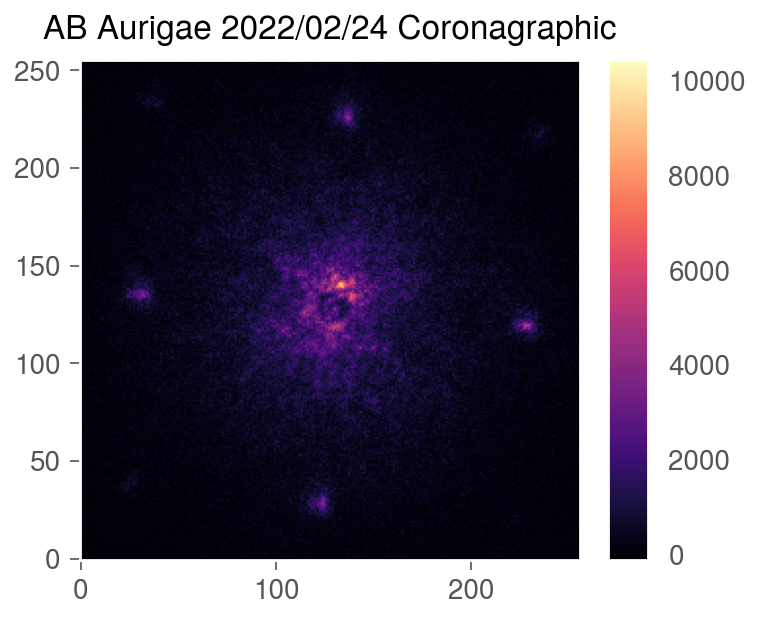

In [10]:
fig, axes = pro.subplots()
frame_idx_coro = 112

frame = abaur20220224_cube[frame_idx_coro]

c = axes[0].imshow(frame, cmap="magma")
fig.colorbar(c)
axes.format(grid=False)
fig.suptitle("AB Aurigae 2022/02/24 Coronagraphic");

In [11]:
from vampires_dpp.image_registration import satellite_spot_offsets
from vampires_dpp.satellite_spots import lamd_to_pixel

# radius of satellite spots
radius = lamd_to_pixel(31.6, abaur20220224_hdr["U_FILTER"])

kwargs = {
    "center": (130, 130),
    "window": 30,
    "radius": radius,
    "refidx": frame_idx_coro,
}


offsets_coro_com = satellite_spot_offsets(abaur20220224_cube, method="com", **kwargs)
offsets_coro_peak = satellite_spot_offsets(abaur20220224_cube, method="peak", **kwargs)
offsets_coro_dft = satellite_spot_offsets(
    abaur20220224_cube, method="dft", refmethod="com", upsample_factor=1, **kwargs
)
offsets_coro_dft_10 = satellite_spot_offsets(
    abaur20220224_cube, method="dft", refmethod="com", upsample_factor=10, **kwargs
)
offsets_coro_moffat = satellite_spot_offsets(
    abaur20220224_cube, method="moffat", **kwargs
)
offsets_coro_gaussian = satellite_spot_offsets(
    abaur20220224_cube, method="gaussian", **kwargs
)
offsets_coro_airydisk = satellite_spot_offsets(
    abaur20220224_cube, method="airydisk", **kwargs
)

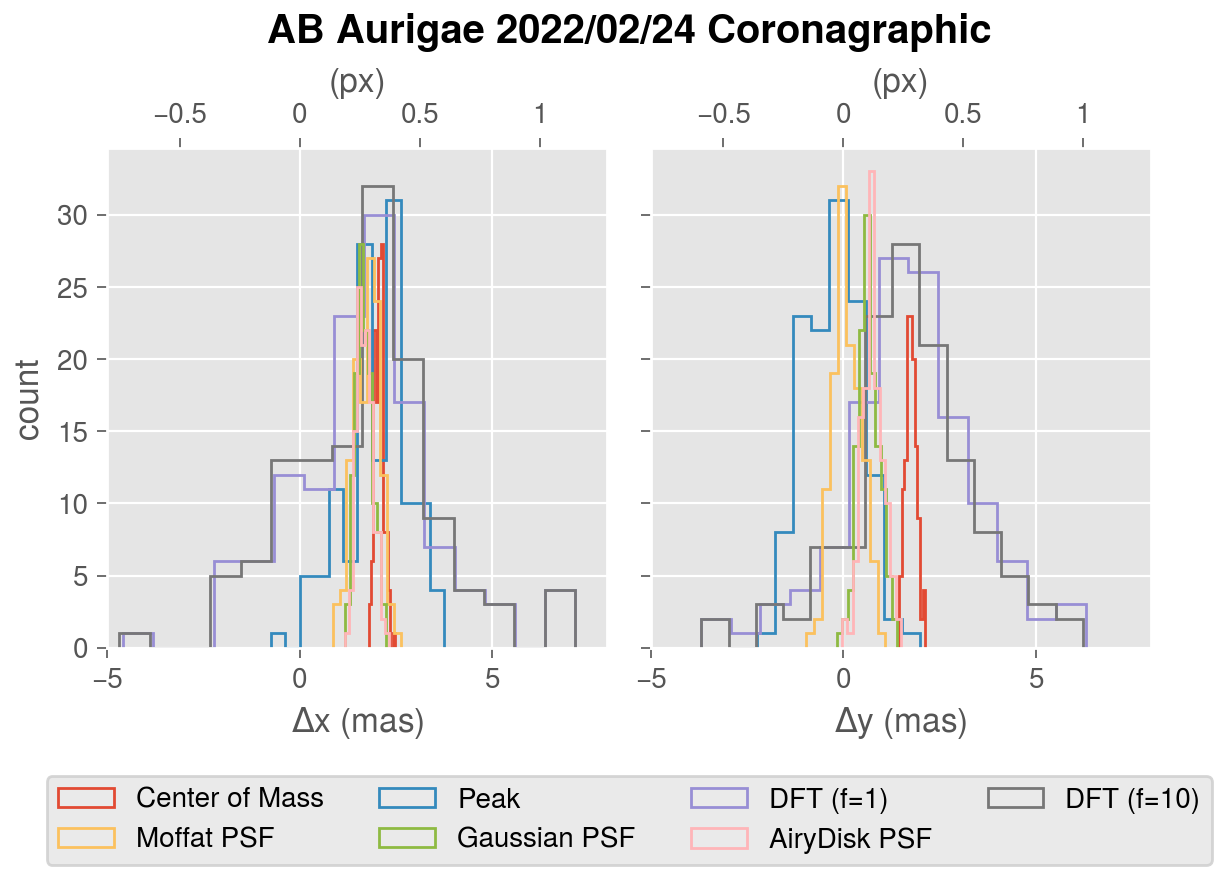

In [12]:
fig, axes = pro.subplots(sharex=0, ncols=2)

offsets_coro = [
    offsets_coro_com,
    offsets_coro_peak,
    offsets_coro_dft,
    offsets_coro_dft_10,
    offsets_coro_moffat,
    offsets_coro_gaussian,
    offsets_coro_airydisk,
]


for label, samples in zip(labels, offsets_coro):
    axes[0].hist(samples[:, 1], bins="auto", fill=False, lw=1, label=label)
    axes[1].hist(samples[:, 0], bins="auto", fill=False, lw=1)
axes[0].format(xlabel=r"$\Delta$x (mas)", ylabel="count")
axes[1].format(xlabel=r"$\Delta$y (mas)")
axes.dualx(lambda a: a / 6.24, label="(px)")
axes.format(xlim=(-5, 8))
fig.format(suptitle="AB Aurigae 2022/02/24 Coronagraphic")
fig.legend(loc="bottom", ncols=4);

In [13]:
from vampires_dpp.image_processing import shift_cube

collapsed_coro_frames = []
for offset in offsets_coro:
    registered_cube = shift_cube(abaur20220224_cube, -offset)
    collapsed_coro_frames.append(
        np.median(registered_cube, axis=0, overwrite_input=True)
    )

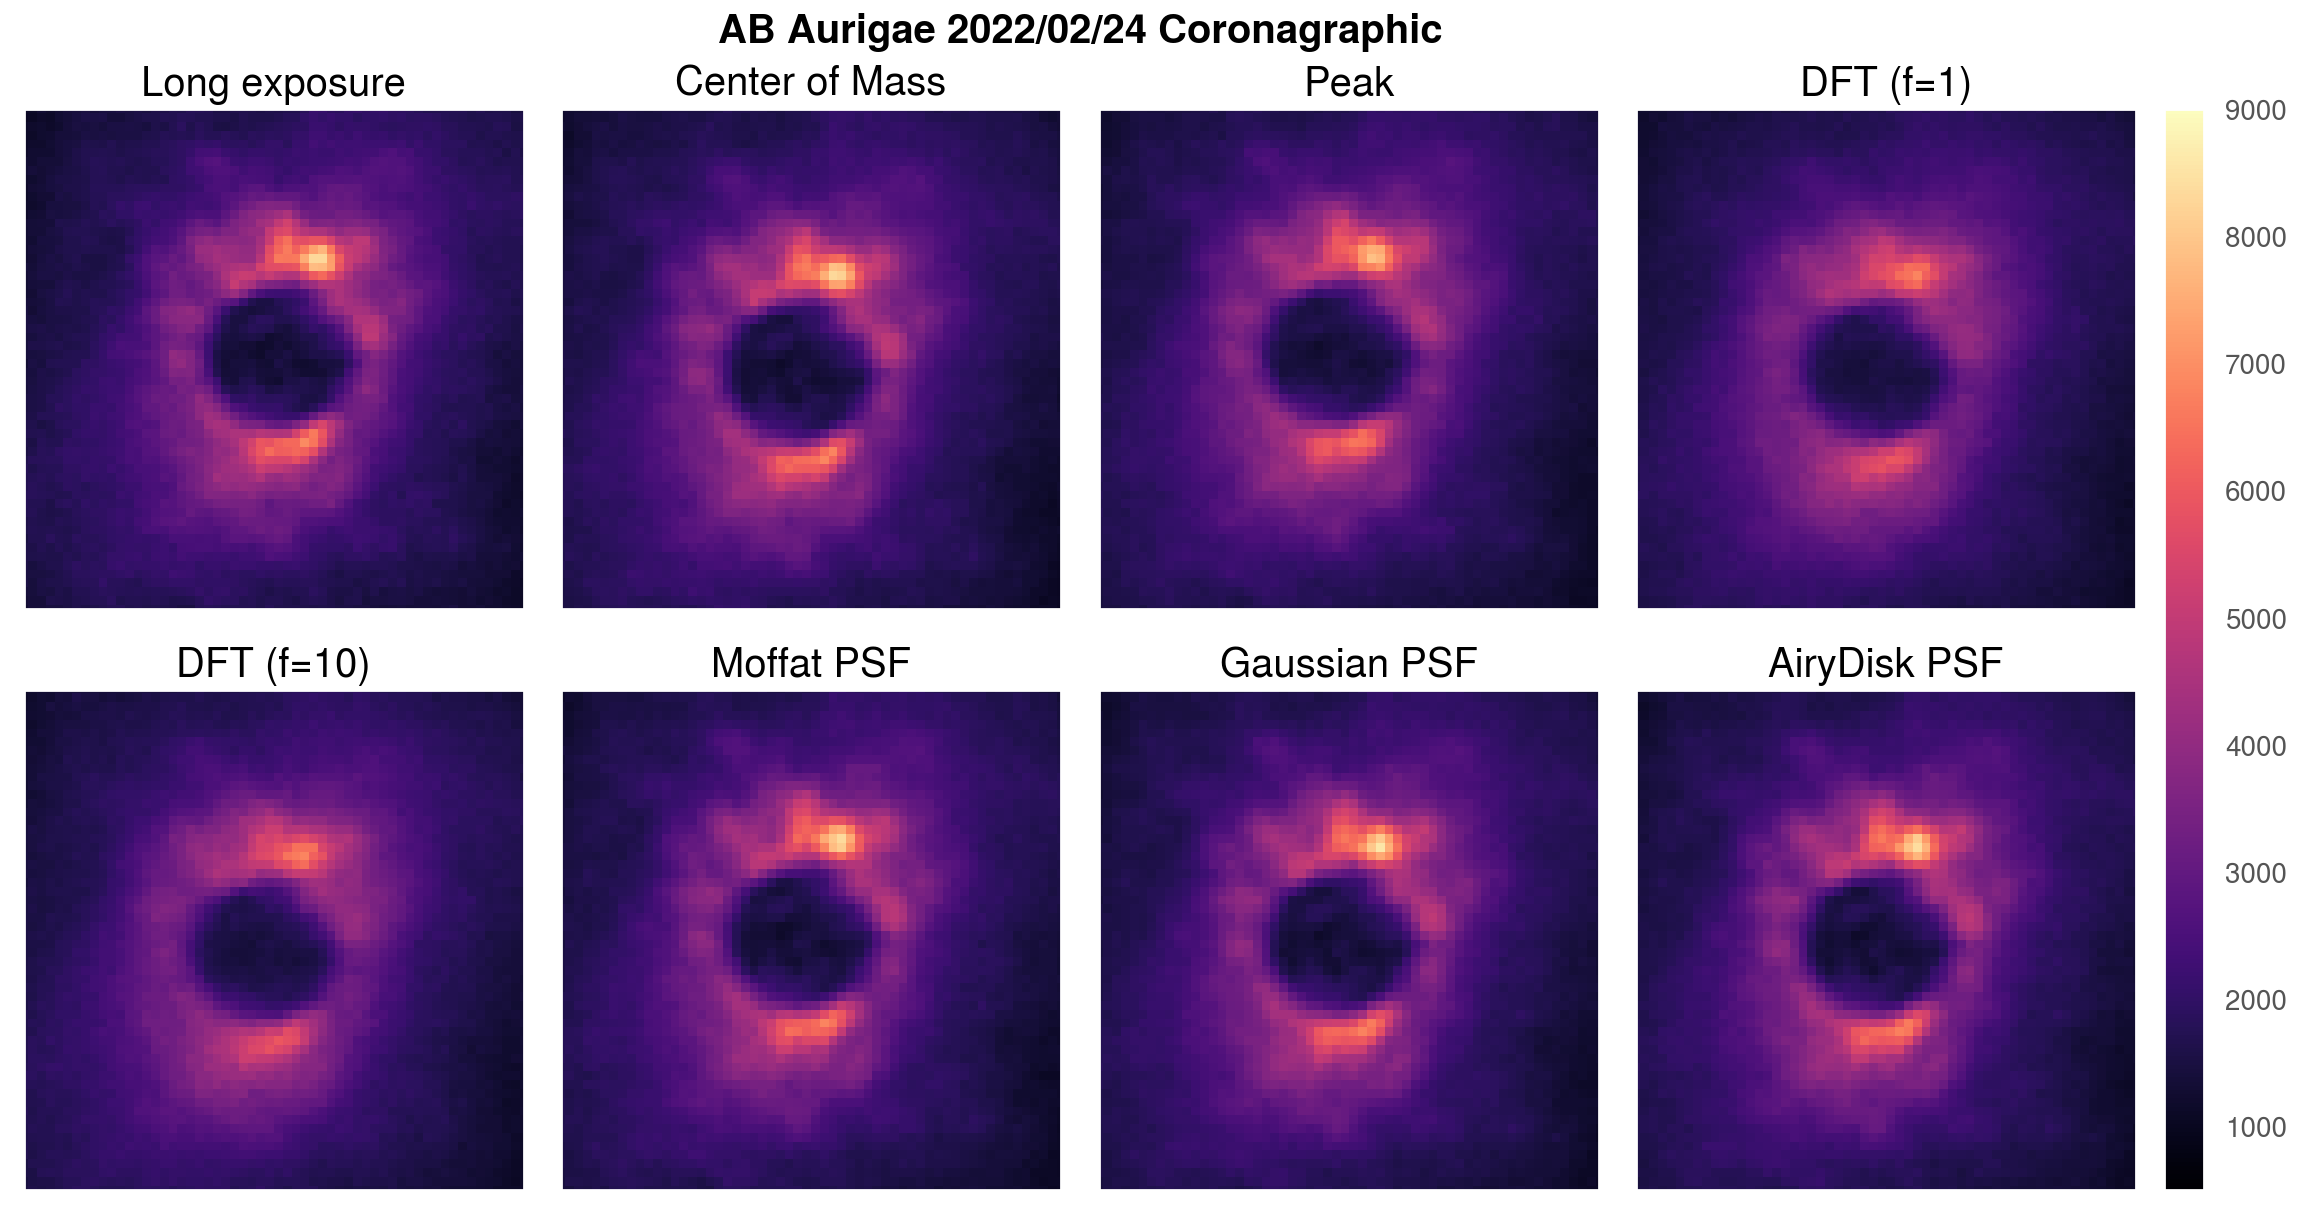

In [14]:
fig, axes = pro.subplots(nrows=2, ncols=4)

long_expo_coro = np.median(abaur20220224_cube, 0)

c = axes[0].imshow(long_expo_coro, cmap="magma", vmin=500, vmax=9e3)
axes[0].format(title="Long exposure")
fig.colorbar(c)

for i, frame, label in zip(range(1, 8), collapsed_coro_frames, labels):
    axes[i].imshow(frame, cmap="magma", vmin=500, vmax=9e3)
    axes[i].format(title=label)

axes.format(xticks=False, yticks=False, xlim=(100, 157), ylim=(100, 157))
fig.format(suptitle="AB Aurigae 2022/02/24 Coronagraphic");

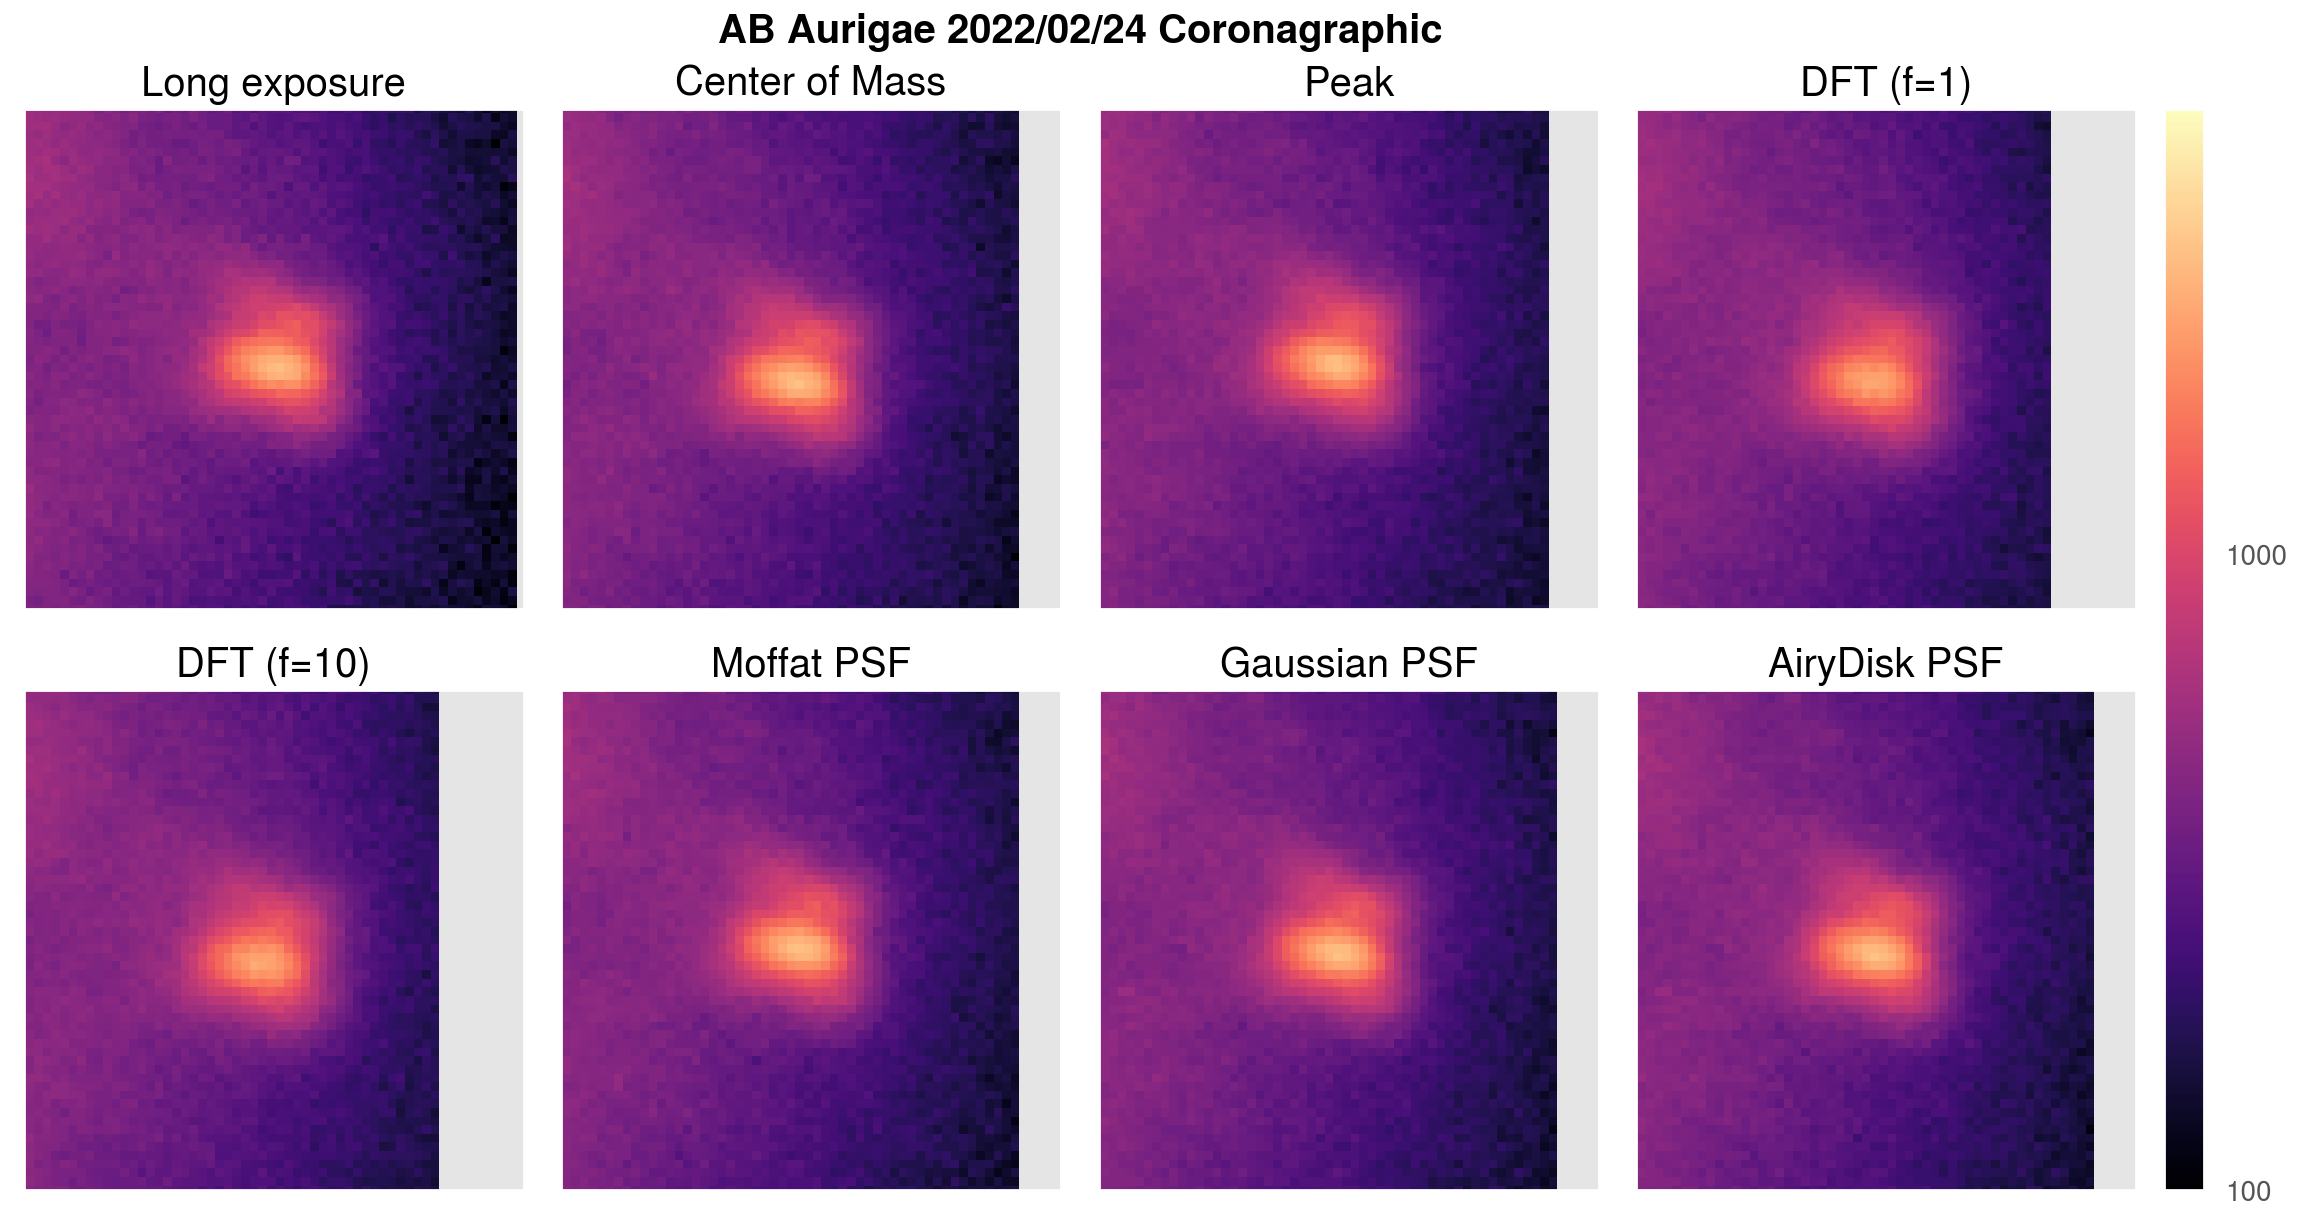

In [15]:
fig, axes = pro.subplots(nrows=2, ncols=4)

c = axes[0].imshow(long_expo_coro, cmap="magma", norm="symlog", vmin=100, vmax=5e3)
axes[0].format(title="Long exposure")
fig.colorbar(c)

for i, frame, label in zip(range(1, 8), collapsed_coro_frames, labels):
    axes[i].imshow(frame, cmap="magma", norm="symlog", vmin=100, vmax=5e3)
    axes[i].format(title=label)

axes.format(
    xticks=False,
    yticks=False,
    xlim=(98 + radius * np.cos(np.deg2rad(-4)), 156 + radius * np.cos(np.deg2rad(-4))),
    ylim=(98 + radius * np.sin(np.deg2rad(-4)), 156 + radius * np.sin(np.deg2rad(-4))),
)
fig.format(suptitle="AB Aurigae 2022/02/24 Coronagraphic");

## Test 3: Coronagraphic Satellite Spots - High S/N

Test using bench data from 2022/06/29

In [16]:
bench_cube, bench_hdr = fits.getdata(
    datadir / "bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits", header=True
)

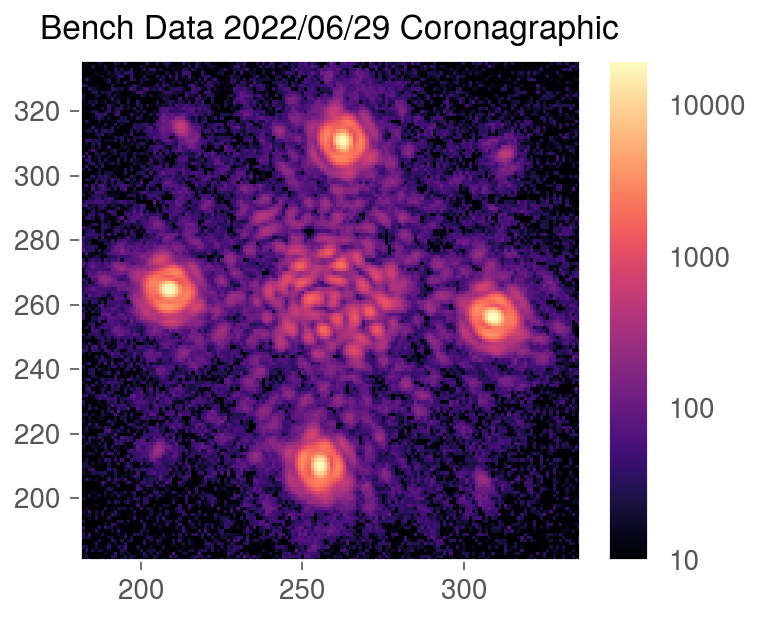

In [17]:
fig, axes = pro.subplots()
frame_idx_bench = bench_cube.max((1, 2)).argmax()

c = axes[0].imshow(
    bench_cube[frame_idx_bench], cmap="magma", norm="symlog", vmin=10, vmax=2e4
)
fig.colorbar(c)
axes.format(grid=False, xlim=(181, 336), ylim=(181, 336))
fig.suptitle("Bench Data 2022/06/29 Coronagraphic");

In [18]:
# radius of satellite spots
radius_bench = lamd_to_pixel(15.8, bench_hdr["U_FILTER"])

kwargs = {
    "center": (264, 262),
    "window": 30,
    "radius": radius_bench,
    "refidx": frame_idx_bench,
    "refmethod": "peak",
}

offsets_bench_com = satellite_spot_offsets(bench_cube, method="com", **kwargs)
offsets_bench_peak = satellite_spot_offsets(bench_cube, method="peak", **kwargs)
offsets_bench_dft = satellite_spot_offsets(
    bench_cube, method="dft", upsample_factor=1, **kwargs
)
offsets_bench_dft_10 = satellite_spot_offsets(
    bench_cube, method="dft", upsample_factor=10, **kwargs
)
offsets_bench_moffat = satellite_spot_offsets(bench_cube, method="moffat", **kwargs)
offsets_bench_gaussian = satellite_spot_offsets(bench_cube, method="gaussian", **kwargs)
offsets_bench_airydisk = satellite_spot_offsets(bench_cube, method="airydisk", **kwargs)

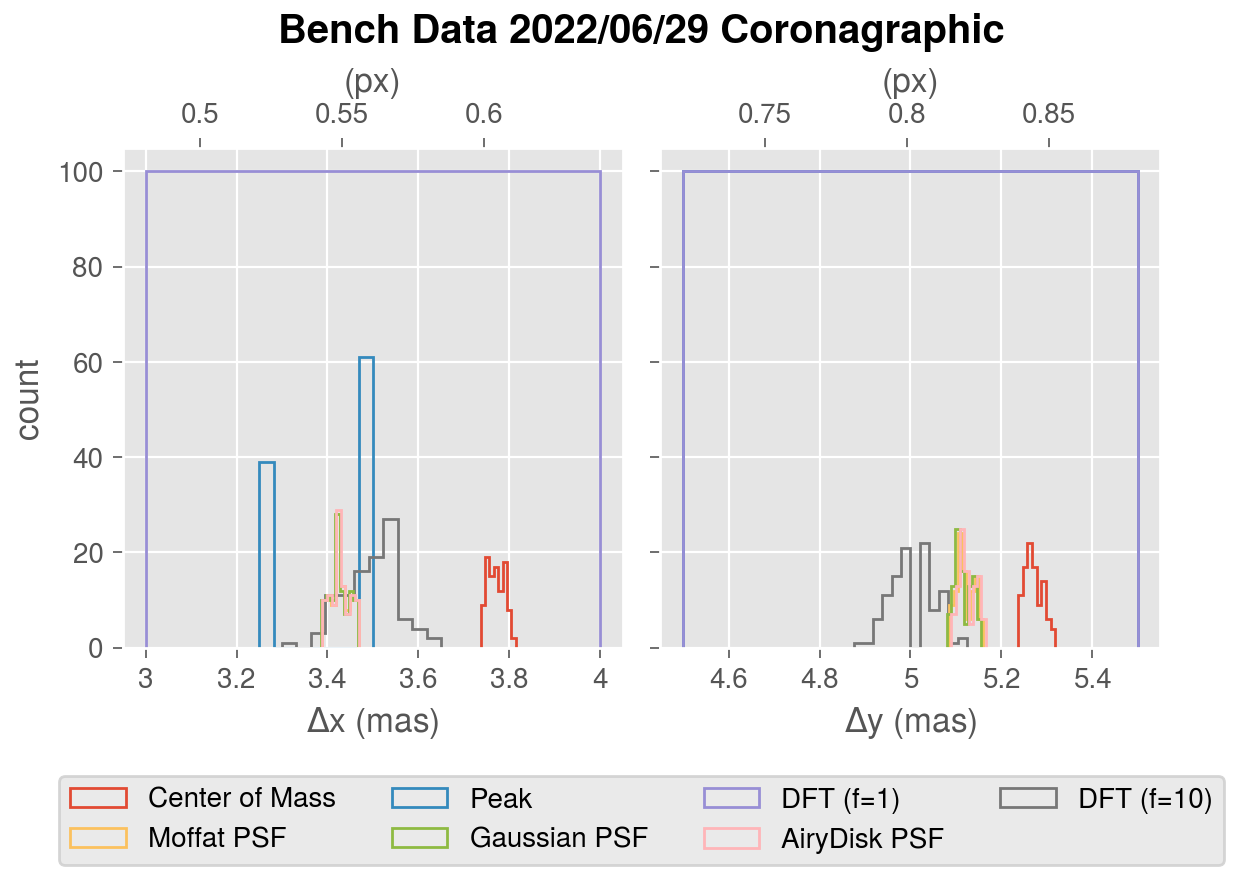

In [19]:
fig, axes = pro.subplots(sharex=0, ncols=2)

offsets_bench = [
    offsets_bench_com,
    offsets_bench_peak,
    offsets_bench_dft,
    offsets_bench_dft_10,
    offsets_bench_moffat,
    offsets_bench_gaussian,
    offsets_bench_airydisk,
]


for label, samples in zip(labels, offsets_bench):
    axes[0].hist(samples[:, 1], bins="auto", fill=False, lw=1, label=label)
    axes[1].hist(samples[:, 0], bins="auto", fill=False, lw=1)
axes[0].format(xlabel=r"$\Delta$x (mas)", ylabel="count")
axes[1].format(xlabel=r"$\Delta$y (mas)")
axes.dualx(lambda a: a / 6.24, label="(px)")
fig.format(suptitle="Bench Data 2022/06/29 Coronagraphic")
fig.legend(loc="bottom", ncols=4);

In [20]:
collapsed_bench_frames = []
for offset in offsets_bench:
    registered_cube = shift_cube(bench_cube, -offset)
    collapsed_bench_frames.append(
        np.median(registered_cube, axis=0, overwrite_input=True)
    )

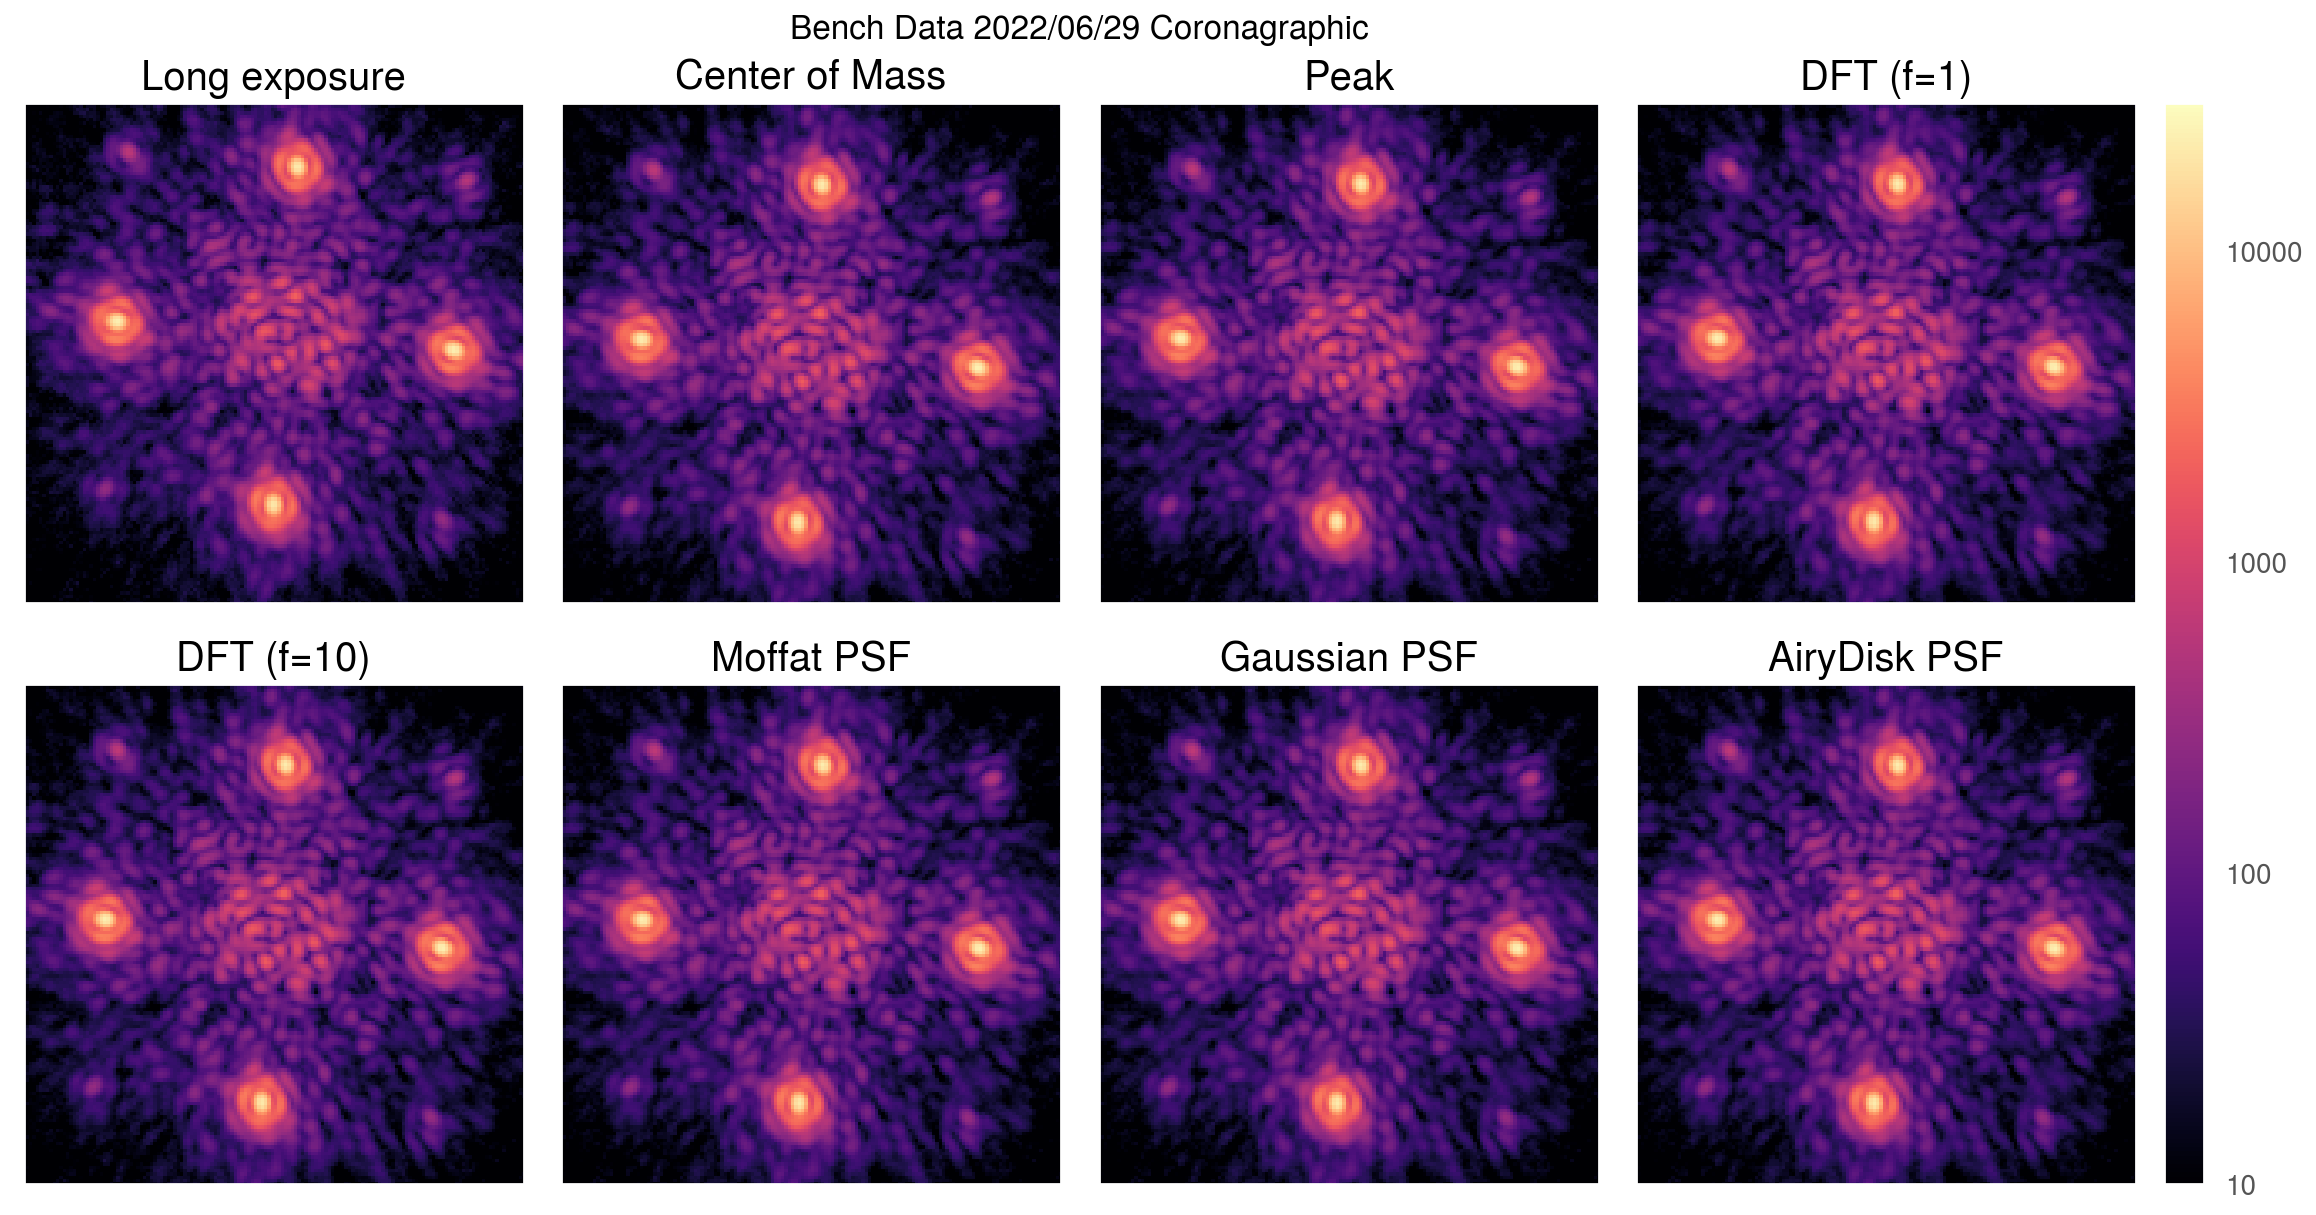

In [21]:
fig, axes = pro.subplots(nrows=2, ncols=4)

long_expo_bench = np.median(bench_cube, 0)

c = axes[0].imshow(long_expo_bench, cmap="magma", norm="symlog", vmin=10, vmax=3e4)
axes[0].format(title="Long exposure")
fig.colorbar(c)

for i, frame, label in zip(range(1, 8), collapsed_bench_frames, labels):
    axes[i].imshow(frame, cmap="magma", norm="symlog", vmin=10, vmax=3e4)
    axes[i].format(title=label)

axes.format(xticks=False, yticks=False, xlim=(181, 330), ylim=(181, 330))
fig.suptitle("Bench Data 2022/06/29 Coronagraphic");

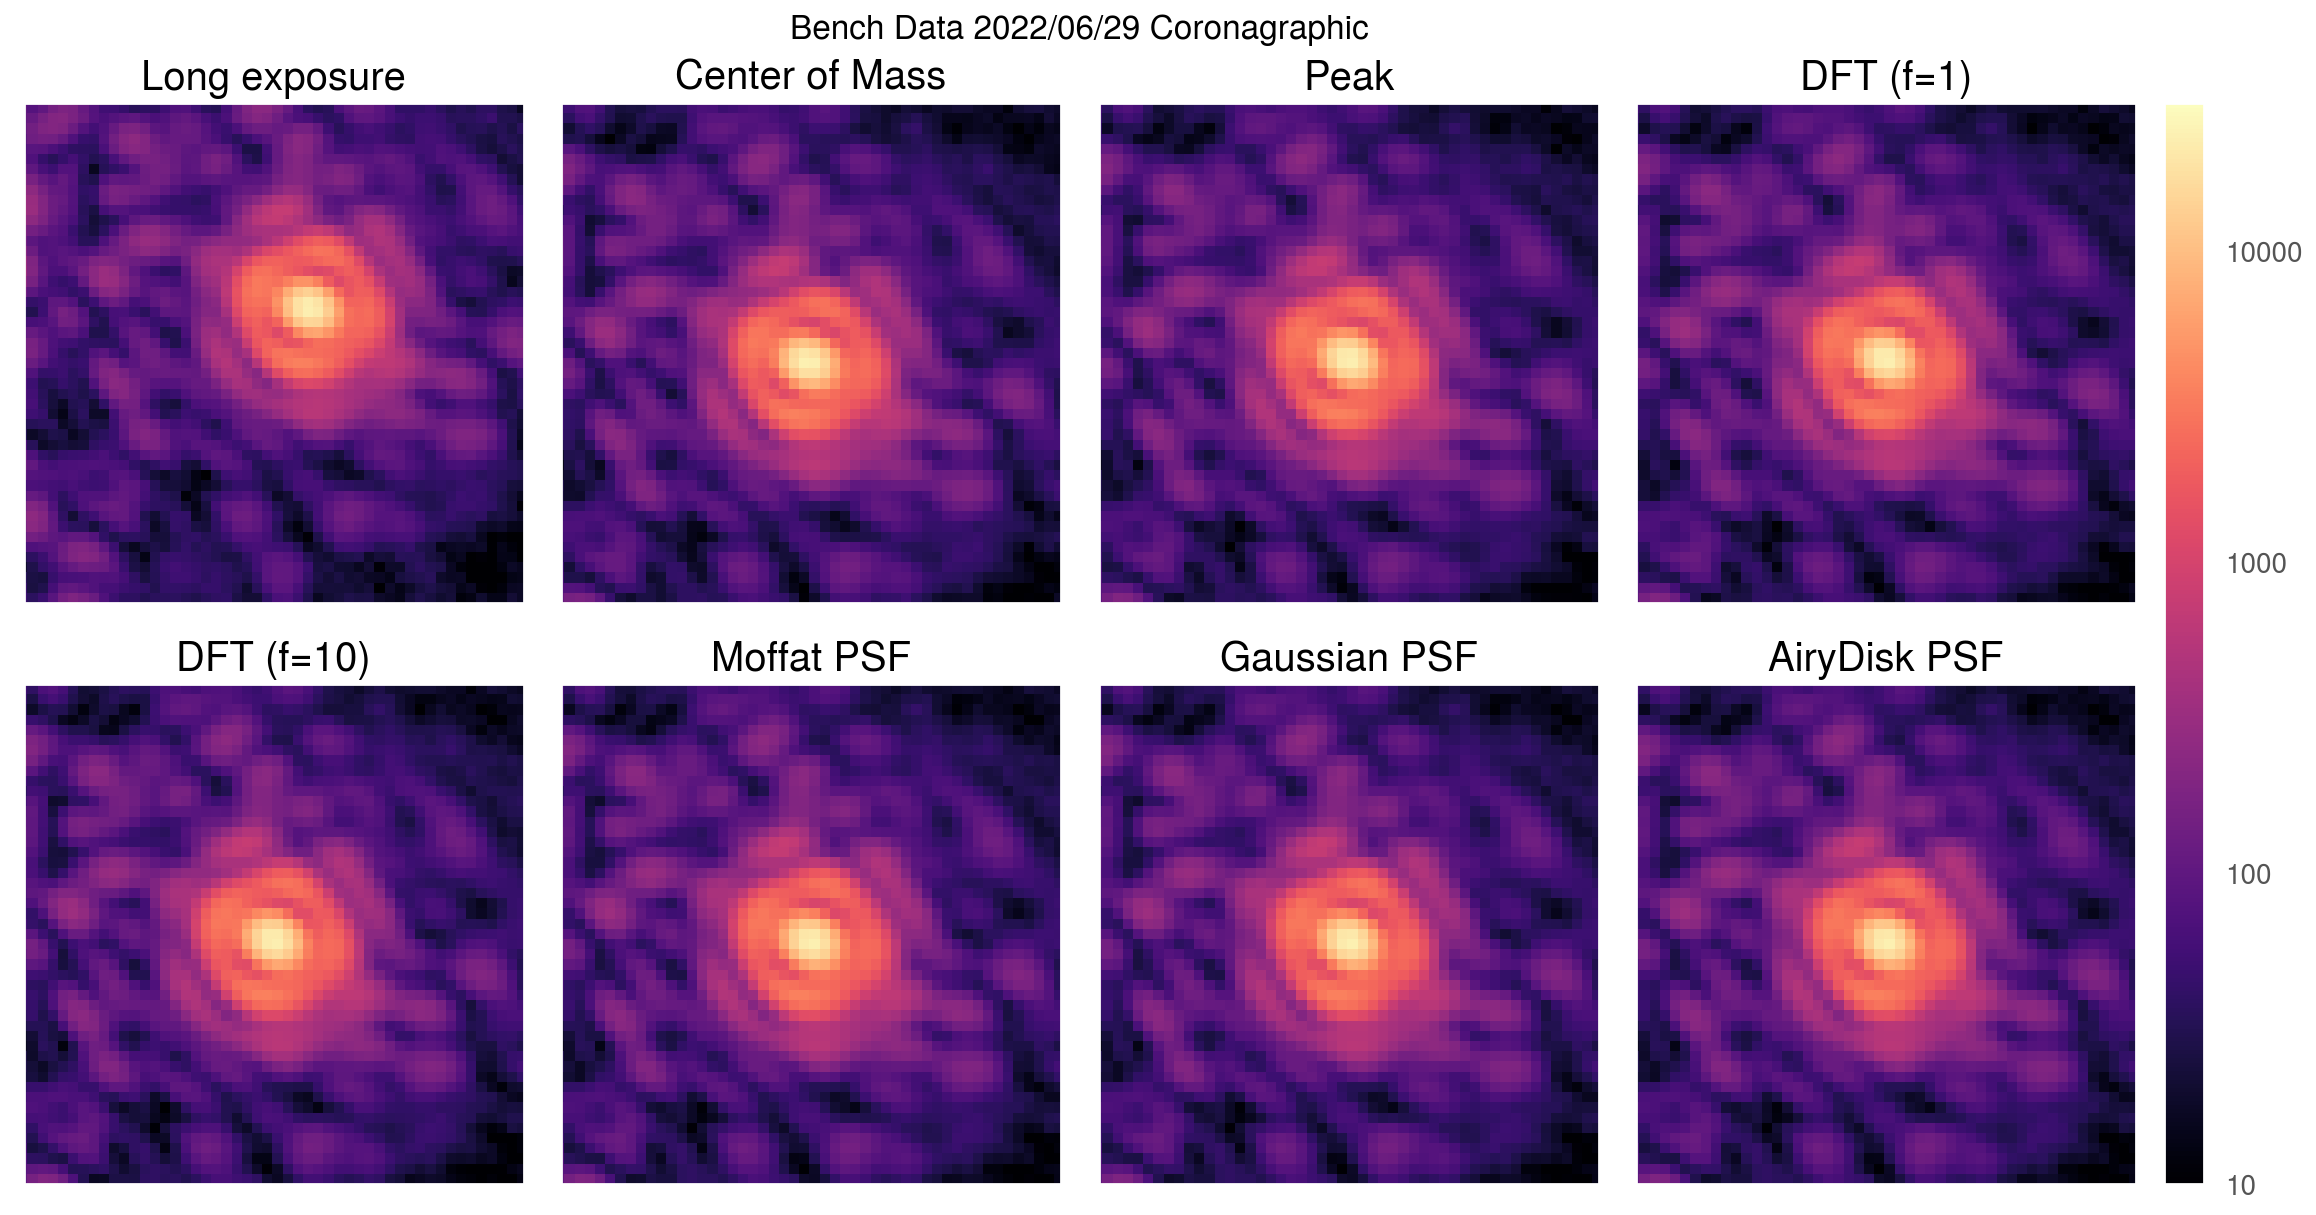

In [22]:
fig, axes = pro.subplots(nrows=2, ncols=4)

c = axes[0].imshow(long_expo_bench, cmap="magma", norm="symlog", vmin=10, vmax=3e4)
axes[0].format(title="Long exposure")
fig.colorbar(c)

for i, frame, label in zip(range(1, 8), collapsed_bench_frames, labels):
    axes[i].imshow(frame, cmap="magma", norm="symlog", vmin=10, vmax=3e4)
    axes[i].format(title=label)

axes.format(
    xticks=False,
    yticks=False,
    xlim=(
        231 + radius_bench * np.cos(np.deg2rad(-4)),
        280 + radius_bench * np.cos(np.deg2rad(-4)),
    ),
    ylim=(
        231 + radius_bench * np.sin(np.deg2rad(-4)),
        280 + radius_bench * np.sin(np.deg2rad(-4)),
    ),
)

fig.suptitle("Bench Data 2022/06/29 Coronagraphic");